<a href="https://colab.research.google.com/github/solpal8/eccdum_assignments/blob/main/Entrega_final_ECD_Azcue%2C_Goicoechea%2C_Gonzalez%2C_Palermo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook overview

The objective of this notebook is to offer a first approximation at Image Classification problems.

For this, we will be using a very popular library `PyTorch` and a DataSet of fruits and vegetables.



---


❗ **Before running the notebook in colab, go to the top menu: `Runtime` > `Change runtime type` > `Hardware accelerator` and select the option "T4 GPU" to ensure faster execution.**

# 1- Instalación de librerías y dataset

In [ ]:
!pip install -q eccd_datasets

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import requests
import io
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from eccd_datasets import load_images
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
resnet_labels = {
    int(index): label
    for index, (id, label) in requests.get(
        "https://files.fast.ai/models/imagenet_class_index.json"
    )
    .json()
    .items()
}
resnet_labels[10]

'brambling'

In [ ]:
df_images = load_images()
df_images.head()

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [ ]:
def load_image_data(image_data):
    return Image.open(io.BytesIO(image_data))

# 2 - Transformaciones al dataset - preprocesamiento

In [ ]:
from torch.utils.data import Dataset, DataLoader
# transformaciones recomendadas por profesor, resize de 256 y center crop de 224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#Necesitamos esta parte para cargar las imágenes, en ejemplo de link se lo guada en el directorio
class ECCDImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

        self.classes = sorted(df['coarse_cat'].unique())
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_bytes = row['image_data']
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

        label = self.class_to_idx[row['coarse_cat']]

        if self.transform:
            image = self.transform(image)

        return image, label

# Cargar el dataset en un DataFrame con load_images()
dataset_df = load_images()

# Crear datasets para cada partición usando los DataFrames correspondientes
image_datasets = {
    x: ECCDImageDataset(dataset_df[dataset_df['dataset'] == x], transform=data_transforms[x])
    for x in ['train', 'val', 'test']
}

# Crear DataLoaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


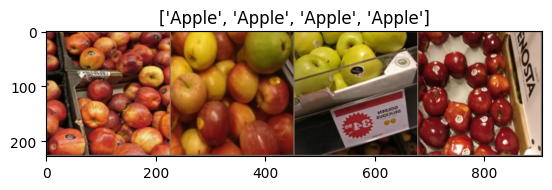

In [ ]:
#esto es para ver algunas de las imágenes
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 3 - Preparación de las funciones para el entrenamiento y visualización de los resultados del modelo

In [ ]:
# definimos entrenamiento de modelo
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # creamos directorio temporal para ir guardando las epocas
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0


                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()


                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # estadísticas
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # copiar el modelo
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # cargar los mejores pesos dados
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [ ]:
# funcion para visualizar el modelo en términos de predicciones y asi evaluarlas
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 4 - Carga de modelo pre-entrenado

In [ ]:
#Se carga modelo pre entrenado
model_ft = models.resnet18(weights='IMAGENET1K_V1')

input_last_layer = model_ft.fc.in_features
output_last_layer = model_ft.fc.out_features
print(f"Number of input features in last layer: {input_last_layer}")
print(f"Number of output features in last layer: {output_last_layer}")

number_of_classes = df_images["coarse_cat"].nunique()

model_ft.fc = nn.Linear(in_features=input_last_layer, out_features=number_of_classes)
input_last_layer = model_ft.fc.in_features
output_last_layer = model_ft.fc.out_features

print(f"Number of input features in last layer: {input_last_layer}")
print(f"Number of output features in last layer: {output_last_layer}")

Number of input features in last layer: 512
Number of output features in last layer: 1000
Number of input features in last layer: 512
Number of output features in last layer: 5


In [ ]:
model_ft = model_ft.to(device) # Para mover el modelo a un dispositivo

criterion = nn.CrossEntropyLoss()

# definición de los parametros para el entrenamiento
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# decrece el learning rate cada 15 epocas
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

In [ ]:
#Necesitamos esta parte del código porque si no rompe, ver si efectivamente valida posteriormente
from tempfile import TemporaryDirectory

# Crear un directorio temporal para guardar los checkpoints del entrenamiento
with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')


# 5 - Entrenamiento y resultados

In [ ]:
#entrenamiento del modelo
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.0108 Acc: 0.6000
val Loss: 0.4690 Acc: 0.7895

Epoch 1/49
----------
train Loss: 0.6185 Acc: 0.7733
val Loss: 0.3943 Acc: 0.8246

Epoch 2/49
----------
train Loss: 0.5173 Acc: 0.8074
val Loss: 0.4239 Acc: 0.8772

Epoch 3/49
----------
train Loss: 0.5206 Acc: 0.8059
val Loss: 0.1470 Acc: 0.9474

Epoch 4/49
----------
train Loss: 0.3758 Acc: 0.8696
val Loss: 0.1857 Acc: 0.9474

Epoch 5/49
----------
train Loss: 0.4070 Acc: 0.8519
val Loss: 0.1979 Acc: 0.9123

Epoch 6/49
----------
train Loss: 0.3780 Acc: 0.8652
val Loss: 0.1256 Acc: 0.9298

Epoch 7/49
----------
train Loss: 0.3491 Acc: 0.8830
val Loss: 0.1838 Acc: 0.9123

Epoch 8/49
----------
train Loss: 0.2580 Acc: 0.9067
val Loss: 0.3381 Acc: 0.8947

Epoch 9/49
----------
train Loss: 0.2698 Acc: 0.9081
val Loss: 0.0828 Acc: 0.9649

Epoch 10/49
----------
train Loss: 0.1964 Acc: 0.9348
val Loss: 0.1158 Acc: 0.9474

Epoch 11/49
----------
train Loss: 0.2510 Acc: 0.9096
val Loss: 0.1817 Acc: 0.9474

Ep

Algunas imágenes con su predicción

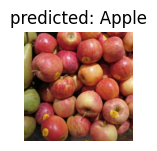

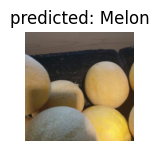

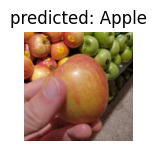

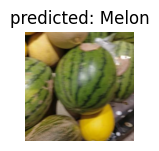

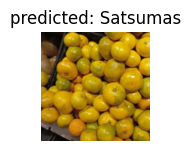

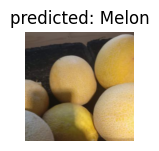

In [ ]:
visualize_model(model_ft)

Resultados del modelo al evaluar conjunto en test

In [ ]:
model_ft.eval()

# Inicializa variables para calcular la accuracy
correct = 0
total = 0

with torch.no_grad():
    all_labels = []
    all_predictions = []
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)

        # salidas del modelo
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)

        # etiquetas reales y predichas
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        # número total de predicciones correctas
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calcula la accuracy
accuracy = 100 * correct / total
print(f'Accuracy del modelo en el conjunto de test: {accuracy:.2f}%')

Accuracy del modelo en el conjunto de test: 89.26%


# 6 - Cálculo de costo/riesgo

In [ ]:
# Código para calcular el costo/riesgo
import numpy as np

# precios de cada producto (por kg)
prices = {
    'Apple': 74,
    'Pear': 89,
    'Satsumas': 44,
    'Melon': 109,
    'Orange': 35
}

# función para calcular el costo/riesgo para cada par de predicción y valor real
def calculate_cost(y_real, y_pred):
    real_price = prices[y_real]
    pred_price = prices[y_pred]

    if pred_price > real_price:
        return 5 * (pred_price - real_price)  # usuario paga de más
    elif pred_price < real_price:
        return real_price - pred_price       # usuario paga de menos
    else:
        return 0                             # usuario paga exactamente lo que pesa

idx_to_class = {v: k for k, v in dataloaders['test'].dataset.class_to_idx.items()}

# índices a nombres de clases
Y_test = [idx_to_class[label] for label in all_labels]
Y_pred = [idx_to_class[pred] for pred in all_predictions]

# costo total para todas las predicciones
total_cost = sum(calculate_cost(y_real, y_pred) for y_real, y_pred in zip(Y_test, Y_pred))

print(f"El costo/riesgo total para el cliente es: ${total_cost}")

El costo/riesgo total para el cliente es: $5544


# 7 - Cálculos y gráficos extras para presentación

Predicciones en cada clase

In [ ]:
#esto lo hacemos para sacar datos sobre las predicciones en cada clase
from collections import defaultdict

def evaluate_predictions(real_labels, pred_labels, class_names):
    correct_counts = defaultdict(int)
    incorrect_counts = defaultdict(lambda: defaultdict(int))

    # recuento de predicciones correctas e incorrectas
    for real, pred in zip(real_labels, pred_labels):
        if real == pred:
            correct_counts[real] += 1
        else:
            incorrect_counts[real][pred] += 1

    # resultados
    for fruit in class_names:
        print(f"Fruta: {fruit}")
        print(f"  Correctas: {correct_counts[fruit]}")
        if fruit in incorrect_counts:
            for incorrect_fruit, count in incorrect_counts[fruit].items():
                print(f"  Incorrectas (predicho como {incorrect_fruit}): {count}")
        else:
            print(f"  Incorrectas: 0")
        print()

class_names = ['Apple', 'Pear', 'Satsumas', 'Melon', 'Orange']
evaluate_predictions(Y_test, Y_pred, class_names)

Fruta: Apple
  Correctas: 548
  Incorrectas (predicho como Satsumas): 2
  Incorrectas (predicho como Pear): 2

Fruta: Pear
  Correctas: 188
  Incorrectas (predicho como Apple): 26
  Incorrectas (predicho como Melon): 2

Fruta: Satsumas
  Correctas: 70
  Incorrectas (predicho como Orange): 66

Fruta: Melon
  Correctas: 294
  Incorrectas (predicho como Orange): 10
  Incorrectas (predicho como Apple): 2

Fruta: Orange
  Correctas: 80
  Incorrectas (predicho como Melon): 4
  Incorrectas (predicho como Satsumas): 24
  Incorrectas (predicho como Apple): 4



Cantidad de imágenes por clase en train

In [ ]:
#con esto contamos la cantidad de imágenes en cada clase en el conjunto de entrenamiento
from collections import Counter

def count_fruits_in_train(dataloader):
    label_counts = Counter()

    for inputs, labels in dataloader:
        # contar las etiquetas
        label_counts.update(labels.cpu().numpy())

    idx_to_class = {v: k for k, v in dataloader.dataset.class_to_idx.items()}

    fruit_counts = {idx_to_class[idx]: count for idx, count in label_counts.items()}

    for fruit, count in fruit_counts.items():
        print(f"{fruit}: {count}")

    return fruit_counts

train_dataloader = dataloaders['train']
fruit_counts = count_fruits_in_train(train_dataloader)

Melon: 154
Apple: 278
Satsumas: 70
Pear: 116
Orange: 57


Gráfico

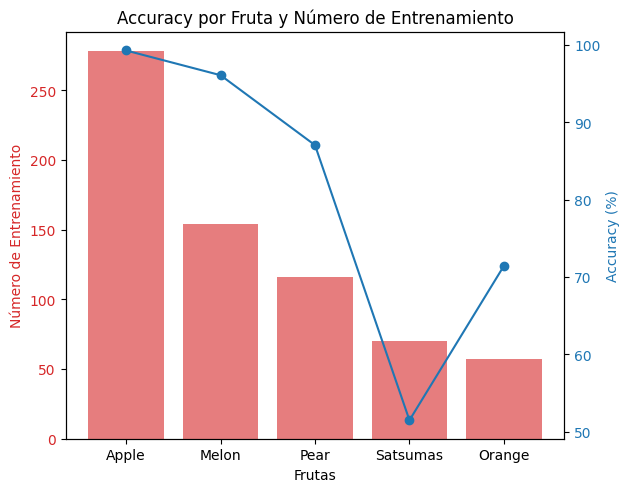

In [ ]:
#funcion para realizar gráfico que muestre accuracy por clase y lo contrarreste con cantidad de imágenes en entrenamiento
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def count_fruits_in_train(dataloader):
    label_counts = Counter()
    for inputs, labels in dataloader:
        label_counts.update(labels.cpu().numpy())
    idx_to_class = {v: k for k, v in dataloader.dataset.class_to_idx.items()}
    fruit_counts = {idx_to_class[idx]: count for idx, count in label_counts.items()}
    return fruit_counts

def evaluate_predictions(real_labels, pred_labels, class_names):
    correct_counts = defaultdict(int)
    total_counts = defaultdict(int)
    for real, pred in zip(real_labels, pred_labels):
        total_counts[real] += 1
        if real == pred:
            correct_counts[real] += 1
    accuracy_per_fruit = {fruit: (correct_counts[fruit] / total_counts[fruit]) * 100 for fruit in class_names}
    return accuracy_per_fruit

# función para generar la gráfica
def plot_accuracy_and_train_counts(accuracy_per_fruit, train_counts):
    # ordenamos los datos
    sorted_fruits = sorted(train_counts, key=train_counts.get, reverse=True)
    sorted_train_counts = [train_counts[fruit] for fruit in sorted_fruits]
    sorted_accuracy = [accuracy_per_fruit[fruit] for fruit in sorted_fruits]

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Frutas')
    ax1.set_ylabel('Número de Entrenamiento', color=color)
    ax1.bar(sorted_fruits, sorted_train_counts, color=color, alpha=0.6, label='Número de Entrenamiento')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy (%)', color=color)
    ax2.plot(sorted_fruits, sorted_accuracy, color=color, marker='o', linestyle='-', label='Accuracy (%)')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Accuracy por Fruta y Número de Entrenamiento')
    plt.show()

train_dataloader = dataloaders['train']
fruit_counts = count_fruits_in_train(train_dataloader)

class_names = ['Apple', 'Pear', 'Satsumas', 'Melon', 'Orange']
accuracy_per_fruit = evaluate_predictions(Y_test, Y_pred, class_names)

plot_accuracy_and_train_counts(accuracy_per_fruit, fruit_counts)